# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [1]:
import tensorflow as tf
import numpy as np

### 1. Load and split preprocessed data

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [4]:
import zipfile
import os

# # prepare the training and testing image sets.
# def unzipDataset(zip_path, extract_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)

# # set the paths
# zip_path = 'nzmsa-2024.zip'
# extract_path = os.getcwd()  

# # unzip the dataset
# unzipDataset(zip_path, extract_path)

In [2]:
from PIL import Image

def loadTrain(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt('train.csv', delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

def loadTest(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# paths to the dataset directories
train_dir = os.path.join('cifar10_images', 'train')
test_dir = os.path.join('cifar10_images', 'test')
train_csv = 'train.csv'

# load training, testing data and the training label provided in train.csv.
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

# normalize the data. Reshape the data to fit in to a MLP or a CNN model.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors.
y_train = to_categorical(y_train, 10)

# Split the train set into a train set and a validation set, 20/80
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### 2. Choose the algorithm

<h4> Multi-Layer Perception (MLP) </h4>
<ol>
    <li>Usage Case: A simple feedforward neural network can be used for basic classification tasks. While not as powerful as CNNs or ViTs for image or text data, MLPs can be effective for smaller datasets or simpler problems.</li>
    <li>Benefits:
        <ol>
            <li>Versatile: Handles classification and regression.</li>
            <li>Powerful: Models complex non-linear relationships.</li>
            <li>Feature Learning: Learns from raw data.</li>
            <li>Scalable: Performance improves with more layers/neurons.</li>
        </ol>
    </li>
    <li>Conditions:
        <ol>
            <li>Data: Requires labeled, numerical data.</li>
            <li>Resources: Needs significant computational power.</li>
            <li>Preprocessing: Data normalisation, handle missing values.</li>
            <li>Tuning: Hyperparameter tuning required.</li>
            <li>Overfitting: Needs dropout, regularisation.</li>
            <li>Training Time: Can be lengthy for large datasets.</li>
        </ol>
    </li>
</ol>

<h4> Convolutional Neural Network (CNN) </h4>
<ol>
    <li>Usage Case: Designed to process data with grid-like topology (e.g. images, video, audio, etc.). CNNs use convolutional layers to extract features from the input data automatically. Examples include AlexNet, VGG, ResNet, EfficientNet, etc.</li>
    <li>Benefits:
        <ol>
            <li>Spatial Hierarchies: Captures image spatial hierarchies.</li>
            <li>Parameter Efficiency: Fewer parameters than fully connected networks.</li>
            <li>Translation Invariance: Detects features irrespective of position.</li>
            <li>Feature Extraction: Learns features from raw images.</li>
            <li>High Accuracy: Excellent performance on image tasks.</li>
        </ol>
    </li>
    <li>Conditions:
        <ol>
            <li>Data: Needs large labeled datasets.</li>
            <li>Resources: Requires GPUs for training.</li>
            <li>Preprocessing: Normalise, resize, augment images.</li>
            <li>Architecture: Careful design of layers, filters.</li>
            <li>Overfitting: Mitigated by dropout, data augmentation.</li>
            <li>Training Time: Lengthy for complex models and large datasets.</li>
        </ol>
    </li>
</ol>

### 3. Train and test the model

<h4> MLP </h4>

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

In [23]:
# Define a learning rate schduler
def lr_schedule(epoch, lr):
    if epoch > 10:
        lr = 0.0005
    if epoch > 15:
        lr = 0.0001
    return lr

X_train_mlp = X_train.reshape(-1, 3072)
X_val_mlp = X_val.reshape(-1, 3072)
X_test_mlp = X_test.reshape(-1, 3072)

# Model initialization.
mlp_model = tf.keras.Sequential()
 
# Build the MLP model.
mlp_model.add(Dense(256, activation='relu', input_shape=(X_train_mlp.shape[1],)))
mlp_model.add(Dropout(0.5)) # add dropout for regularisation
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dropout(0.5)) # add dropout for regularisation
mlp_model.add(Dense(10,  activation="softmax"))

# Complile the model.
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model.
mlp_model.fit(X_train_mlp, y_train, epochs=20, batch_size=64, validation_data=(X_val_mlp, y_val), callbacks=[LearningRateScheduler(lr_schedule)])

# Make predictions.
mlp_predictions = mlp_model.predict(X_test_mlp)
mlp_predicted_labels = np.argmax(mlp_predictions, axis=1)

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 2.3166 - accuracy: 0.0983 - val_loss: 2.3027 - val_accuracy: 0.0979 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 5s 8ms/step - loss: 2.3030 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.1017 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3027 - accuracy: 0.1006 - val_loss: 2.3028 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3027 - accuracy: 0.1004 - val_loss: 2.3028 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 2.3027 - accuracy: 0.1021 - val_loss: 2.3028 - val_accuracy: 0.0973 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 2.3027 - accuracy: 0.0995 - val_loss: 2.3028 - val_accuracy: 0.0933 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - lo

<h4> CNN </h4>

In [11]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

In [41]:
X_train_cnn = X_train.reshape(-1, 32, 32, 3)
X_val_cnn = X_val.reshape(-1, 32, 32 ,3)
X_test_cnn = X_test.reshape(-1, 32, 32, 3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train_cnn)

# Initialize CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(layers.Dense(10, activation='softmax'))

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(datagen.flow(X_train_cnn, y_train, batch_size=64), epochs=20, validation_data=(X_val_cnn, y_val), callbacks=[LearningRateScheduler(lr_schedule)])

# Make predictions
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

Epoch 1/20
625/625 [==============================] - 54s 85ms/step - loss: 2.4503 - accuracy: 0.3205 - val_loss: 2.6488 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 55s 87ms/step - loss: 1.9934 - accuracy: 0.4216 - val_loss: 3.6807 - val_accuracy: 0.1586 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 1.7790 - accuracy: 0.4708 - val_loss: 2.1438 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 54s 87ms/step - loss: 1.6652 - accuracy: 0.4971 - val_loss: 3.2996 - val_accuracy: 0.2089 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 54s 87ms/step - loss: 1.6121 - accuracy: 0.5106 - val_loss: 1.8989 - val_accuracy: 0.4259 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 58s 93ms/step - loss: 1.5985 - accuracy: 0.5136 - val_loss: 1.3767 - val_accuracy: 0.5894 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 58s 

### 4. Evaluate the model

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

<h4> MLP </h4>

313/313 [==============================] - 1s 2ms/step


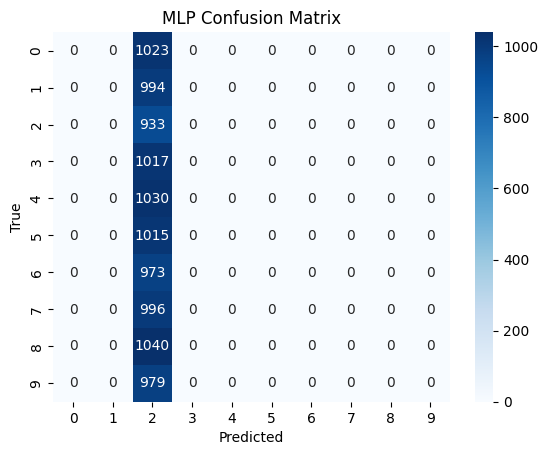

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1023
           1       0.00      0.00      0.00       994
           2       0.09      1.00      0.17       933
           3       0.00      0.00      0.00      1017
           4       0.00      0.00      0.00      1030
           5       0.00      0.00      0.00      1015
           6       0.00      0.00      0.00       973
           7       0.00      0.00      0.00       996
           8       0.00      0.00      0.00      1040
           9       0.00      0.00      0.00       979

    accuracy                           0.09     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.09      0.02     10000

MLP Accuracy: 0.09


d:\anaconda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Evaluate the model
mlp_val_predictions = mlp_model.predict(X_val_mlp)
mlp_val_predicted_labels = np.argmax(mlp_val_predictions, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Confusion Matrix
mlp_cm = confusion_matrix(y_val_labels, mlp_val_predicted_labels)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
mlp_report = classification_report(y_val_labels, mlp_val_predicted_labels)
print('MLP Classification Report:')
print(mlp_report)

# Accuracy
mlp_accuracy = accuracy_score(y_val_labels, mlp_val_predicted_labels)
print(f'MLP Accuracy: {mlp_accuracy:.2f}')

In [43]:
# Retrain the MLP model using the entire training set
mlp_model.fit(np.concatenate([X_train_mlp, X_val_mlp]), np.concatenate([y_train, y_val]), 
              epochs=10, batch_size=64, callbacks=[LearningRateScheduler(lr_schedule)])

# Predict test data
mlp_test_predictions = mlp_model.predict(X_test_mlp)
mlp_test_predicted_labels = np.argmax(mlp_test_predictions, axis=1)

# Save prediction results
submission = np.column_stack((id_test, mlp_test_predicted_labels))
np.savetxt('submission_mlp.csv', submission, delimiter=',', header='id,label', comments='', fmt='%d')

Epoch 1/10
782/782 [==============================] - 6s 8ms/step - loss: 2.3026 - accuracy: 0.0997 - lr: 1.0000e-04
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0988 - lr: 1.0000e-04
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0965 - lr: 1.0000e-04
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3026 - accuracy: 0.0967 - lr: 1.0000e-04
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0976 - lr: 1.0000e-04
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0958 - lr: 1.0000e-04
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0976 - lr: 1.0000e-04
Epoch 8/10
782/782 [==============================] - 6s 7ms/step - loss: 2.3026 - accuracy: 0.0989 - lr: 1.0000e-04
Epoch 9/10
782/782 [==============================] - 6s 7ms/ste

<h4> CNN </h4>

313/313 [==============================] - 4s 12ms/step


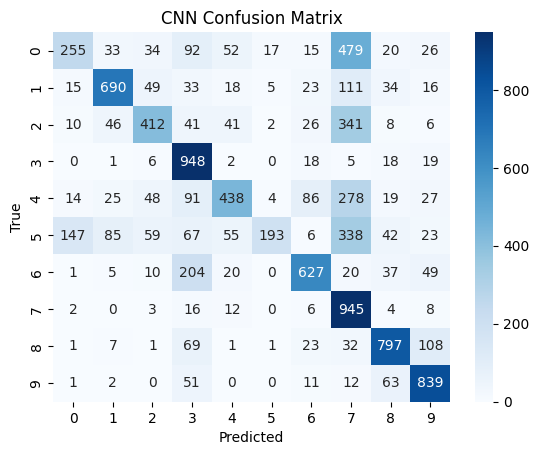

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.25      0.35      1023
           1       0.77      0.69      0.73       994
           2       0.66      0.44      0.53       933
           3       0.59      0.93      0.72      1017
           4       0.69      0.43      0.52      1030
           5       0.87      0.19      0.31      1015
           6       0.75      0.64      0.69       973
           7       0.37      0.95      0.53       996
           8       0.76      0.77      0.77      1040
           9       0.75      0.86      0.80       979

    accuracy                           0.61     10000
   macro avg       0.68      0.61      0.60     10000
weighted avg       0.68      0.61      0.59     10000

CNN Accuracy: 0.61


In [37]:
# Evaluate the model
cnn_val_predictions = cnn_model.predict(X_val_cnn)
cnn_val_predicted_labels = np.argmax(cnn_val_predictions, axis=1)
# y_val_labels = np.argmax(y_val, axis=1)

# Confusion Matrix
cnn_cm = confusion_matrix(y_val_labels, cnn_val_predicted_labels)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
cnn_report = classification_report(y_val_labels, cnn_val_predicted_labels)
print('CNN Classification Report:')
print(cnn_report)

# Accuracy
cnn_accuracy = accuracy_score(y_val_labels, cnn_val_predicted_labels)
print(f'CNN Accuracy: {cnn_accuracy:.2f}')

In [45]:
# Retrain the CNN model using the entire training set
cnn_model.fit(datagen.flow(np.concatenate([X_train_cnn, X_val_cnn]), np.concatenate([y_train, y_val]), batch_size=64),
              epochs=20, callbacks=[LearningRateScheduler(lr_schedule)])

# Predict test data
cnn_test_predictions = cnn_model.predict(X_test_cnn)
cnn_test_predicted_labels = np.argmax(cnn_test_predictions, axis=1)

# Save prediction results
submission = np.column_stack((id_test, cnn_test_predicted_labels))
np.savetxt('submission_cnn.csv', submission, delimiter=',', header='id,label', comments='', fmt='%d')

Epoch 1/20
782/782 [==============================] - 64s 82ms/step - loss: 1.3046 - accuracy: 0.6089 - lr: 5.0000e-04
Epoch 2/20
782/782 [==============================] - 66s 85ms/step - loss: 1.3131 - accuracy: 0.6034 - lr: 5.0000e-04
Epoch 3/20
782/782 [==============================] - 65s 83ms/step - loss: 1.3082 - accuracy: 0.6073 - lr: 5.0000e-04
Epoch 4/20
782/782 [==============================] - 71s 91ms/step - loss: 1.3089 - accuracy: 0.6085 - lr: 5.0000e-04
Epoch 5/20
782/782 [==============================] - 72s 92ms/step - loss: 1.3046 - accuracy: 0.6095 - lr: 5.0000e-04
Epoch 6/20
782/782 [==============================] - 72s 91ms/step - loss: 1.3084 - accuracy: 0.6108 - lr: 5.0000e-04
Epoch 7/20
782/782 [==============================] - 72s 92ms/step - loss: 1.2990 - accuracy: 0.6157 - lr: 5.0000e-04
Epoch 8/20
782/782 [==============================] - 72s 92ms/step - loss: 1.3092 - accuracy: 0.6082 - lr: 5.0000e-04
Epoch 9/20
782/782 [============================

### 5. Summary

<h4> What I have found during training and evaluation </h4>
<ol>
    <li>For this image classification problem with lots of data, CNN model always performs better than MLP model, which corresponds with the usage cases for these two deep learning algorithms.</li>
</ol>

<h4> Training and evaluation steps </h4>
<h5> MLP model </h5>
<ol>
    <li>Data reshaped to a 2D format.</li>
    <li>MLP model built with dense layers and dropout for regularization.</li>
    <li>Model trained for 20 epochs with a batch size of 64.</li>
    <li>Learning rate schedule applied.</li>
    <li>Initial evaluation on validation data during training.</li>
    <li>Model retrained using combined training and validation sets, and predictions made on test data.</li>
</ol>
<h5> CNN model </h5>
<ol>
    <li>Data reshaped to a 4D format suitable for CNNs.</li>
    <li>CNN model built with convolutional layers, batch normalization, and dropout.</li>
    <li>Model trained for 20 epochs with a batch size of 64 using augmented data.</li>
    <li>Learning rate schedule applied.</li>
    <li>Initial evaluation on validation data during training.</li>
    <li>Model retrained using combined training and validation sets, and predictions made on test data.</li>
</ol>

<h4> Next steps to improve the models </h4>
<h5> MLP model </h5>
<ol>
    <li>Tune hyperparameters.</li>
    <li>Experiment with different activation functions.</li>
    <li>Increase training epochs and/or batch size.</li>
    <li>Implement early stopping to avoid overfitting.</li>
</ol>
<h5> CNN model </h5>
<ol>
    <li>Tune hyperparameters and adjust convolutional layers.</li>
    <li>Try different optimizers.</li>
    <li>Implement early stopping and model checkpointing.</li>
</ol>